# Proper Motions

In here, we'll wind the clock back and see what happens to average distance to cluster centers as a function of time. We'll restrict the analysis to only those stars that have Gaia radial velocity measurements (for now).

The analysis proceeds as follows:
1. Get Simbad catalog info for the clusters under study. Consider these to be the cluster centers.
2. Get cluster membership list from [this GAIA Paper](http://simbad.u-strasbg.fr/simbad/sim-ref?bibcode=2018A%26A...616A..10G)
3. Get Gaia records for each star in the membership list
4. Convert coordinates of cluster centers and members to galactic 3d, likewise their proper motions to 3d
5. Create a time scale over which to apply motions
6. For each time step:

    a. For both cluster center and cluster members, compute new position as:
    $$
    Position_t = Position_0 + \frac{dPosition}{dt}\times\Delta t
    $$
    b. Compute Eucliedean distance from cluster center (at time $t$) to each cluster member (also at time $t$)
    
    c. Return mean distance and standard deviation

7. Plot the results

In [24]:
#if running in google colab, uncomment the following:
#!git clone https://github.com/kevinmcmanus/cas-tau.git
#!pip install astroquery
#!pip install pyvo

In [25]:
# necessary modules

import sys
#sys.path.append('./cas-tau/src')
#sys.path.append('./src')

import astropy.coordinates as coord
from astropy.table import QTable, Table, vstack

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

%matplotlib inline

#from cluster import cluster as cl
from fieldstars import fieldstars as fs

In [26]:
from astropy.visualization import quantity_support
quantity_support() 

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x231c2a66548>

## Get Simbad Catalog Entries for Some Open Clusters

In [27]:
clusters = ['Blanco 1',
 'Collinder 140',
 'Coma Berenices Cluster',
 'Hyades',
 'IC 2391',
 'IC 2602',
 'IC 4665',
 'NGC 2232',
 'NGC 2422',
 'NGC 2451A',
 'NGC 2516',
 'NGC 2547',
 'NGC 3532',
 'NGC 6475',
 'NGC 6633',
 'NGC 7092',
 'Pleiades',
 'Praesepe',
 'alpha Per']

In [28]:
# set up the Simbad query
from astroquery.simbad import Simbad
from astropy.time import Time
mySimbad = Simbad()
mySimbad.add_votable_fields('parallax', 'pm','velocity','typed_id')
mySimbad.get_votable_fields()


['main_id', 'coordinates', 'parallax', 'pm', 'velocity', 'typed_id']

In [29]:
#from astropy.table import Table, vstack
res_table = vstack([mySimbad.query_object(c) for c in clusters],join_type='exact')


In [30]:
#fix the Simbad result to a more usable form
cluster_info=Table(res_table['TYPED_ID', 'PLX_VALUE', 'PLX_PREC','RA', 'RA_PREC', 'DEC', 'DEC_PREC',
                            'PMRA', 'PMDEC', 'RVZ_RADVEL', 'RVZ_ERROR'])

#gotta be a better way to do this:
cluster_info['TYPED_ID'] = [c.decode('utf-8') for c in cluster_info['TYPED_ID']]

#rename the columns to look like Gaia
cluster_info.rename_column('TYPED_ID','cluster')
cluster_info.rename_column('PLX_VALUE','parallax')
cluster_info.rename_column('PLX_PREC', 'parallax_error')
cluster_info.rename_column('RA', 'ra')
cluster_info.rename_column('RA_PREC','ra_error')
cluster_info.rename_column('DEC', 'dec')
cluster_info.rename_column('DEC_PREC','dec_error')
cluster_info.rename_column('PMRA', 'pmra')
cluster_info.rename_column('PMDEC', 'pmdec')
cluster_info.rename_column('RVZ_RADVEL','radial_velocity')
cluster_info.rename_column('RVZ_ERROR', 'rv_error')

#unmask the columns
cluster_info = cluster_info.filled() 


#index on the cluster name
cluster_info.add_index('cluster')

# coordinates,  note the update to J2015.5 to match with Gaia
cluster_info['coords'] = \
    SkyCoord(ra = cluster_info['ra'],
        dec = cluster_info['dec'], unit = (u.hour, u.deg),
        obstime = 'J2000',  #simbad returns J2000 coords
        distance = coord.Distance(parallax=Quantity(cluster_info['parallax'])),
        pm_ra_cosdec = cluster_info['pmra'],
        pm_dec = cluster_info['pmdec'],
        radial_velocity = cluster_info['radial_velocity']).apply_space_motion(new_obstime=Time('2015.5',format='decimalyear'))

In [31]:
cluster_info.loc['Pleiades']

cluster,parallax,parallax_error,ra,ra_error,dec,dec_error,pmra,pmdec,radial_velocity,rv_error,coords
,mas,,"""h:m:s""",,"""d:m:s""",,mas / yr,mas / yr,km / s,km / s,"deg,deg,pc"
str22,float64,int16,str13,int16,str13,int16,float64,float64,float64,float32,object
Pleiades,7.364,3,03 47 00,4,+24 07.0,4,19.997,-45.548,5.650,0.090,"56.75009432548025,24.11647057028541,135.7958527032827"


## Get List of Known  Cluster Members

[Abstract](http://simbad.u-strasbg.fr/simbad/sim-ref?bibcode=2018A%26A...616A..10G)

In [32]:
#Get the cluster membership list from the study
members = pd.read_csv('ftp://cdsarc.u-strasbg.fr/pub/cats/J/A+A/616/A10/tablea1a.dat',
                      delim_whitespace=True,
                      header=None, index_col=None,
                      names = ['SourceID', 'Cluster', 'RAdeg', 'DEdeg', 'Gmag', 'plx', 'e_plx'])
members.set_index('SourceID', inplace=True)

In [33]:
#create map to Simbad cluster names
#first get the cluster names as they appear in table1a.dat
cluster_names = members.Cluster.unique()
cluster_names

array(['Hyades', 'ComaBer', 'Pleiades', 'Praesepe', 'alphaPer', 'IC2391',
       'IC2602', 'Blanco1', 'NGC2451'], dtype=object)

In [34]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
name_mapper = {'Hyades': 'Hyades',
               'ComaBer': 'Coma Berenices Cluster',
               'Pleiades': 'Pleiades',
               'Praesepe': 'Praesepe',
               'alphaPer': 'alpha Per',
               'IC2391': 'IC 2391',
               'IC2602': 'IC 2602',
               'Blanco1': 'Blanco 1',
               'NGC2451': 'NGC 2451A'}

In [35]:
#tack the name on for each cluster member
members['SimbadClusterName'] = members.Cluster.apply(lambda c:name_mapper[c])

In [36]:
members.head()

,Cluster,RAdeg,DEdeg,Gmag,plx,e_plx,SimbadClusterName
SourceID,,,,,,,
49520255665123328,Hyades,64.87461,21.75372,12.861,20.866,0.033,Hyades
49729231594420096,Hyades,60.20378,18.19388,5.790,21.789,0.045,Hyades
51383893515451392,Hyades,59.80696,20.42805,12.570,22.737,0.006,Hyades
145373377272257664,Hyades,66.06127,21.73605,6.990,23.109,0.003,Hyades
145391484855481344,Hyades,67.00371,21.61972,5.643,19.968,0.067,Hyades


In [37]:
# number of members in each cluster
members.reset_index().groupby('Cluster').count().SourceID

Cluster
Blanco1      489
ComaBer      153
Hyades       515
IC2391       325
IC2602       492
NGC2451      400
Pleiades    1326
Praesepe     938
alphaPer     740
Name: SourceID, dtype: int64

In [38]:
#get Astropy SkyCoords for each cluster member
members['coords'] = SkyCoord(ra = np.array(members.RAdeg)*u.degree,
        dec = np.array(members.DEdeg)*u.degree,
        obstime = Time('2015.5',format='decimalyear'),  #Gaia ref epoch is 2015.5
        distance = coord.Distance(parallax=Quantity(np.array(members.plx)*u.mas)))


In [39]:
#distance of each star from its cluster center
members['dist_c3d']=[s[1].coords.separation_3d(cluster_info.loc[s[1].SimbadClusterName]['coords']) for s in members.iterrows()]

#convert to dimensionless scalar for plotting purposes (Grrrr)
members['dist_c3d_nq'] = Quantity(members.dist_c3d, unit=u.pc).value

#also get out distance from earth/sun
members['r_est'] = [s.distance.value for s in members.coords]

### Cluster Distance from Sun

Text(0.5, 1.0, 'Member Distance from Sun')

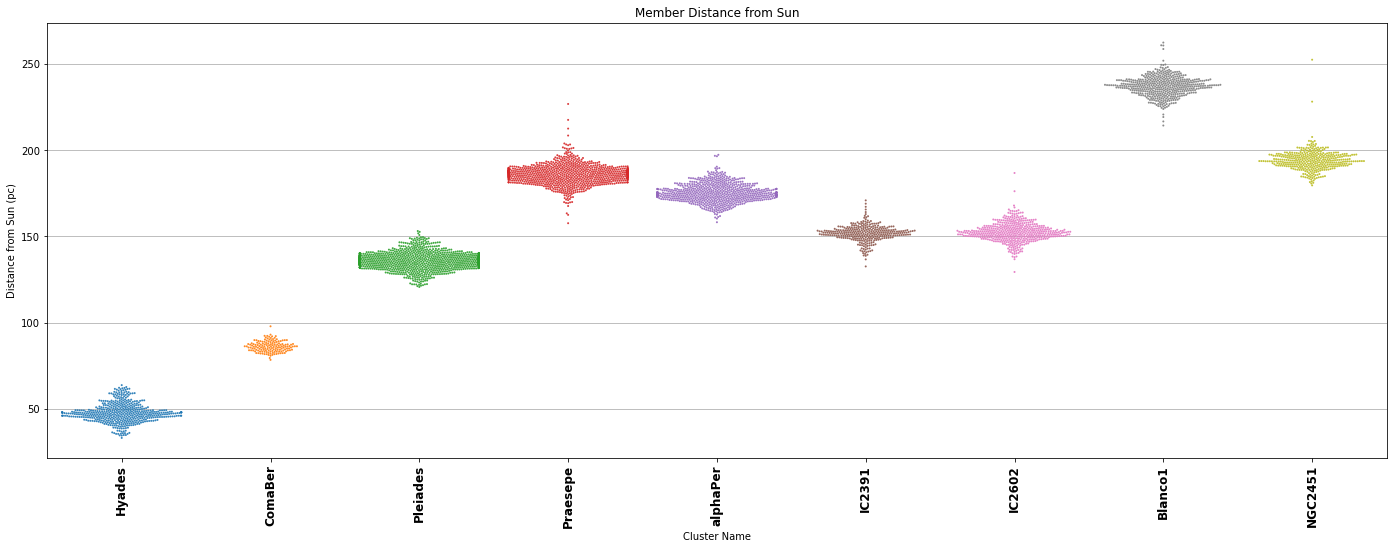

In [40]:
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,1,1)
sns.swarmplot(x="Cluster",y='r_est', data=members,ax=ax, s=2, alpha=0.9)
zz=plt.xticks(rotation=90)
ax.set_ylabel('Distance from Sun (pc)')
ax.set_xticklabels(ax.get_xticklabels(),fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xlabel('Cluster Name')
ax.grid(axis='y')
ax.set_title('Member Distance from Sun')

### Cluster Member Distance from Cluster Center

Text(0.5, 1.0, 'Member Distance from Cluster Center')

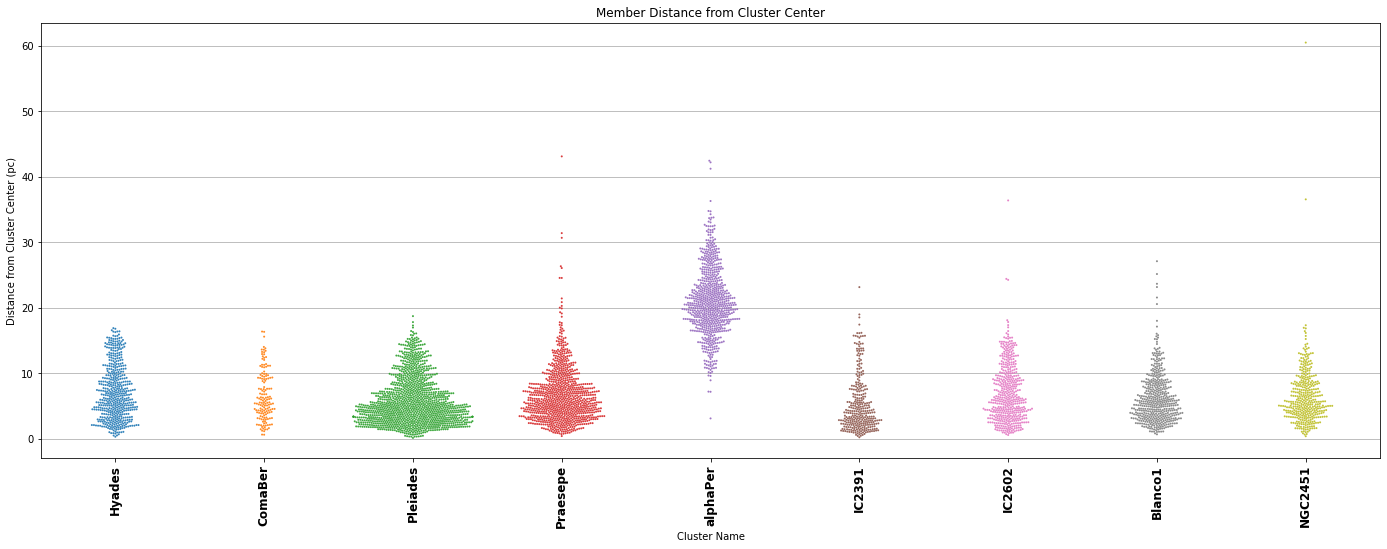

In [41]:
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,1,1)
sns.swarmplot(x="Cluster",y='dist_c3d_nq', data=members,ax=ax,s=2,alpha=0.9)
zz=plt.xticks(rotation=90)
ax.set_ylabel('Distance from Cluster Center (pc)')
ax.set_xticklabels(ax.get_xticklabels(),fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xlabel('Cluster Name')
ax.grid(axis='y')
ax.set_title('Member Distance from Cluster Center')

## Get Gaia Record for Each Member

In [42]:
# Fetch up the Gaia records for all of the cluster members, each cluster at a time
members_gaia = {}
for cl in cluster_names:
    true_members = list(members.query('Cluster == @cl').index)
    members_gaia[cl] = fs(f'from Gaia: {cl}')
    members_gaia[cl].from_source_idlist(true_members)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [43]:
#How many records in each?
for cl in cluster_names:
    print(f'Cluster name: {cl}, Gaia Records: {len(members_gaia[cl].objs)}')

Cluster name: Hyades, Gaia Records: 515
Cluster name: ComaBer, Gaia Records: 153
Cluster name: Pleiades, Gaia Records: 1326
Cluster name: Praesepe, Gaia Records: 938
Cluster name: alphaPer, Gaia Records: 740
Cluster name: IC2391, Gaia Records: 325
Cluster name: IC2602, Gaia Records: 492
Cluster name: Blanco1, Gaia Records: 489
Cluster name: NGC2451, Gaia Records: 400


## How Many Gaia Records Have Radial Velocity?

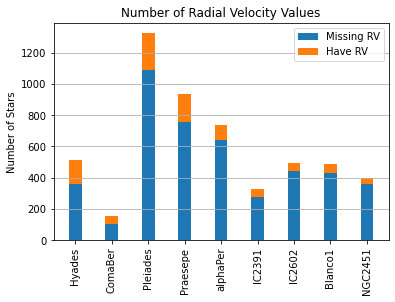

In [44]:
#count missing and valid RV values for each cluster
missing_rv = np.array([np.isnan(members_gaia[cl].objs.radial_velocity).sum() for cl in cluster_names])
have_rv = np.array([np.logical_not(np.isnan(members_gaia[cl].objs.radial_velocity)).sum() for cl in cluster_names])

#create stacked bar chart
ind = np.arange(len(cluster_names))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, missing_rv, width)
p2 = plt.bar(ind, have_rv, width, bottom=missing_rv)

plt.ylabel('Number of Stars')
plt.title('Number of Radial Velocity Values')
plt.xticks(ind, cluster_names, rotation=90)

plt.legend((p1[0], p2[0]), ('Missing RV', 'Have RV'))
plt.grid(axis='y')

## Get Postion and Velocity for Cluster Centers

In [45]:
pos_vel_cen = {}
for cl in cluster_names:
    simname = name_mapper[cl]
    c = cluster_info.loc[simname]['coords']
    pos = np.array([c.galactic.cartesian.x.value,
                    c.galactic.cartesian.y.value,
                    c.galactic.cartesian.z.value])
    vel = np.array([c.galactic.velocity.d_x.value,
                    c.galactic.velocity.d_y.value,
                    c.galactic.velocity.d_z.value])
    
    pos_vel_cen[cl] = {'position': pos, 'velocity':vel}

## Get Postion and Velocity __Only__ for Stars with Radial Velocity

In [46]:
pos_vel_mem = {}
for cl in cluster_names:
    #get SkyCoord objects for each cluster member
    coords = members_gaia[cl].get_coords()
    
    #from the SkyCoords, get position and velocity in galactic coords
    pos = np.array([[g.x.value, g.y.value, g.z.value] for g in coords.galactic.cartesian])
    vel = np.array([[g.d_x.value, g.d_y.value, g.d_z.value] for g in coords.galactic.velocity])
    
    #keep only the rows that have valid d_x, d_y and d_z (i.e. only those with RV measurements)
    mask = np.logical_not(np.any(np.isnan(vel), axis=1))
    
    pos_vel_mem[cl] = {'position':pos[mask], 'velocity':vel[mask]}

## Calculate Mean Distance from Center at Time $t$

In [47]:
def dist_from_center(center, members, t):
    """
    returns mean distance (in parsec) and standard deviation of members from center at a given time t
    Arguments:
        center: cluster center position and velocity (2-element dict, 1x3 vectors)
        members: cluster members' position and velocity (2-element dict, nx3 arrays)
            postion: x, y, z in parsec
            velocity: d_x, d_y, d_z in km/s
        t: time in years
    """
    
    # km to parsec conversion factor
    pc_per_km = (1.0*u.km).to(u.pc).value
    
    # get t in seconds
    tsec = (t*u.year).to(u.second).value
    
    #center postion at time tsec
    cen_delta_pos = center['velocity'] * tsec # in km
    cen_delta_pos_pc = cen_delta_pos * pc_per_km #now in parsec
    cen_pos = center['position'] + cen_delta_pos_pc
    
    # members' positons at time tsec:
    mem_delta_pos = members['velocity'] * tsec # in km
    mem_delta_pos_pc = mem_delta_pos * pc_per_km # convert to parsec
    mem_pos = members['position'] + mem_delta_pos_pc
    
    #3D x,y,z offset from center (relies on numpy broadcasting 1d shape to 2d)
    dist_delta_3d = mem_pos - cen_pos
    # calculate Euclidean distance (in pc)
    dist_from_cen = np.sqrt((dist_delta_3d**2).sum(axis=1))
    
    #get summary stats:
    m = dist_from_cen.mean()
    s = dist_from_cen.std()
    
    #return as a tuple, mean as first member, stddev as second
    return (m,s)

In [48]:
# go from -1B years to +1B years in increments of 1M years
star_times, time_step = np.linspace(-1e9, 1e9, 2001, retstep=True)
print(f'Timestep: {time_step:,}')

Timestep: 1,000,000.0


In [49]:
#do the deed
member_dist_from_center = {}
for cl in cluster_names:
    print(f'Calculating: {cl}')
    msd = np.array([dist_from_center(pos_vel_cen[cl],pos_vel_mem[cl], t) for t in star_times])
    member_dist_from_center[cl] = {'MeanDistance':msd[:,0], 'StdDev': msd[:,1]}

Calculating: Hyades
Calculating: ComaBer
Calculating: Pleiades
Calculating: Praesepe
Calculating: alphaPer
Calculating: IC2391
Calculating: IC2602
Calculating: Blanco1
Calculating: NGC2451


## Plot Results

Text(0.5, 1.0, 'Mean Distance from Center by Cluster')

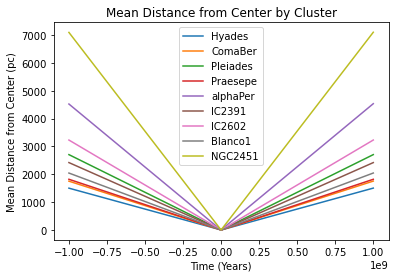

In [53]:
for cl in cluster_names:
    plt.plot(star_times, member_dist_from_center[cl]['MeanDistance'], label=cl)
    
plt.legend()
plt.xlabel('Time (Years)')
plt.ylabel('Mean Distance from Center (pc)')
plt.title('Mean Distance from Center by Cluster')

In [51]:
#mean distance at timestep 1000 which is year 0 (present time)
for cl in cluster_names:
    print('cluster: {}, Mean Dist: {}'.format(cl, member_dist_from_center[cl]['MeanDistance'][1000]))

cluster: Hyades, Mean Dist: 6.66382860477021
cluster: ComaBer, Mean Dist: 6.0222803902489215
cluster: Pleiades, Mean Dist: 5.3638887778956725
cluster: Praesepe, Mean Dist: 5.456912339953744
cluster: alphaPer, Mean Dist: 20.991993801220925
cluster: IC2391, Mean Dist: 4.697814564019114
cluster: IC2602, Mean Dist: 6.0962981227587685
cluster: Blanco1, Mean Dist: 5.566719404156791
cluster: NGC2451, Mean Dist: 6.522360147072694


## Conclusions

Needs work!

- Symetric shape of curve not surprising.

- Why is curve not a curve?

- Does zooming in over shorter time horizon  reveal any pattern?

